In [1]:
from torch_geometric.datasets import MoleculeNet
import torch
import numpy as np
import pandas as pd
import models
from sklearn import metrics

## Import Dataset

In [2]:
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np
import math

class FingerprintDataset(Dataset):
    def __init__(self,split):
        # Initialize data, download, etc.
        # read with numpy or pandas
        xy = np.loadtxt(f'/home/rajeckidoyle/Documents/Classification/BACE_Classification/model_benchmarks/fingerprints/{split}_bace_fingerprints_classification.csv', delimiter=',', dtype=np.float32, skiprows=1)

        self.x = torch.from_numpy(xy[:,1:])
        self.y = torch.from_numpy(xy[:,[0]])
        self.n_samples = xy.shape[0]

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x[index], self.y[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

In [3]:
train_dataset = FingerprintDataset('train')
test_dataset = FingerprintDataset('test')

In [4]:
#Specify device
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

## Set Hyperparameters

In [5]:
import best_config

#Get Model Parameters
hyperparameters = eval('best_config.'+best_config.GLOBALPARAMETERS['model_this_run']+'_HYPERPARAMETERS')

model_params = hyperparameters
model_params['feature_size'] = train_dataset.x.shape[1]

## Define Model

In [6]:
from torch.utils.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

# Root mean squared error
loss_fn = torch.nn.BCELoss()

NUM_FINGERPRINTS_PER_BATCH = model_params['batch_size']

# Wrap data in a data loader
train_loader = DataLoader(train_dataset, 
                    batch_size=NUM_FINGERPRINTS_PER_BATCH, shuffle=True)
test_loader = DataLoader(test_dataset, 
                    batch_size=NUM_FINGERPRINTS_PER_BATCH, shuffle=True)

## Training Loop

In [7]:
def train(model, optimizer, loader):
        model.train()
        # Enumerate over the data
        final_loss = 0
        for i, (fingerprint, labels) in enumerate(loader):  
            fingerprint = fingerprint.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(fingerprint)
            loss = loss_fn(outputs, labels)
            # Backward and optimize
            optimizer.zero_grad()
            final_loss += loss.item()
            loss.backward()
            optimizer.step() 
        return final_loss / len(loader)

def get_results(binary_results):
    accuracy = metrics.accuracy_score(binary_results["y_real"],binary_results["y_pred"])
    f1 = metrics.f1_score(binary_results["y_real"],binary_results["y_pred"])
    precision = metrics.precision_score(binary_results["y_real"],binary_results["y_pred"])
    recall = metrics.recall_score(binary_results["y_real"],binary_results["y_pred"])
    roc_auc = metrics.roc_auc_score(binary_results["y_real"],binary_results["y_pred"])
    tn, fp, fn, tp = metrics.confusion_matrix(binary_results["y_real"],binary_results["y_pred"], labels=[0,1]).ravel()
    specificity = tn / (tn+fp)

    results = {
        'Accuracy':accuracy,
        'F1': f1,
        'Precision': precision,
        'Recall': recall,
        'ROCAUC': roc_auc,
        'Specificity': specificity,
        'TN': tn,
        'FP': fp,
        'FN': fn,
        "TP": tp,
    }

    return results

def test(model, loader):
    model.eval()
    true_values = []
    predictions = []
    with torch.no_grad():
        for fingerprint, labels in loader:
            fingerprint = fingerprint.to(device)
            labels = labels.to(device)
            output = model(fingerprint)
            true_values += labels.tolist()
            predictions += output.tolist()
    df = pd.DataFrame({'y_pred':predictions,'y_real':true_values})
    df = df.applymap(lambda x : x[0])
    output = df["y_pred"].apply(lambda x: int(round(x,0)))
    binary_results = df.applymap(lambda x : int(round(x,0)))
    return df, binary_results, output, get_results(binary_results)


model_this_run = 'MLP'

summary_columns = {
    'Accuracy':[],
    'F1': [],
    'Precision': [],
    'Recall': [],
    'ROCAUC': [],
    'Specificity': [],
    'TN': [],
    'FP': [],
    'FN': [],
    "TP": [],
}
summary = pd.DataFrame(summary_columns)

best_acc = 0

filepath = '/home/rajeckidoyle/Documents/Classification/BACE_Classification/model_benchmarks/'

for i in range(10):
    print(f"Starting training {i}")
    model = eval('models.'+best_config.GLOBALPARAMETERS['model_this_run']+'(model_params)')
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=model_params['learning_rate'])  
    for epoch in range(300): 
        loss = train(model, optimizer, train_loader)
    _, _, _, results = test(model, test_loader)
    if results['Accuracy'] > best_acc:
        best_acc = results['Accuracy']
        torch.save(model.state_dict(), filepath+'best_models/'+model_this_run+'_model.pt')
    results_this_run = pd.DataFrame([results])
    summary = summary.append(results_this_run)


summary.to_csv(filepath + 'results/'+model_this_run+'summary_test.csv')
summary


Starting training 0
Starting training 1


KeyboardInterrupt: 

## Evaluate on the Test Set

In [ ]:
import pandas as pd 
model.eval()
true_values = []
predictions = []
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for fingerprint, labels in test_loader:
        fingerprint = fingerprint.to(device)
        labels = labels.to(device)
        output = model(fingerprint)
        true_values += labels.tolist()
        predictions += output.tolist()
df = pd.DataFrame({'y_pred':predictions,'y_real':true_values})
df = df.applymap(lambda x : x[0])
df
output = df["y_pred"].apply(lambda x: int(round(x,0)))
output
binary_results = df.applymap(lambda x : int(round(x,0)))
binary_results

,y_pred,y_real
0,0,0
1,1,0
2,1,0
3,1,1
4,0,0
...,...,...
298,0,0
299,1,1
300,1,0
301,1,1


## Model Evaluation

In [ ]:
output = df["y_pred"].apply(lambda x: int(round(x,0)))
output
binary_results = df.applymap(lambda x : int(round(x,0)))
binary_results

,y_pred,y_real
0,0,0
1,1,0
2,1,0
3,1,1
4,0,0
...,...,...
298,0,0
299,1,1
300,1,0
301,1,1


In [ ]:

filepath = '/home/rajeckidoyle/Documents/Classification/BACE_Classification/model_benchmarks/results/'
summary.to_csv(filepath + best_config.GLOBALPARAMETERS['model_this_run']+'summary.csv')
summary

,Accuracy,F1,Precision,Recall,ROCAUC,Specificity,TN,FP,FN,TP
0,0.808581,0.780303,0.746377,0.817460,0.809860,0.802260,142.0,35.0,23.0,103.0
0,0.815182,0.789474,0.750000,0.833333,0.817797,0.802260,142.0,35.0,21.0,105.0
0,0.808581,0.778626,0.750000,0.809524,0.808717,0.807910,143.0,34.0,24.0,102.0
0,0.821782,0.793893,0.764706,0.825397,0.822303,0.819209,145.0,32.0,22.0,104.0
0,0.808581,0.781955,0.742857,0.825397,0.811003,0.796610,141.0,36.0,22.0,104.0
0,0.788779,0.753846,0.731343,0.777778,0.787194,0.796610,141.0,36.0,28.0,98.0
0,0.805281,0.772201,0.751880,0.793651,0.803605,0.813559,144.0,33.0,26.0,100.0
0,0.798680,0.771536,0.730496,0.817460,0.801386,0.785311,139.0,38.0,23.0,103.0
0,0.808581,0.778626,0.750000,0.809524,0.808717,0.807910,143.0,34.0,24.0,102.0
0,0.825083,0.798479,0.766423,0.833333,0.826271,0.819209,145.0,32.0,21.0,105.0


### Confusion Matrix

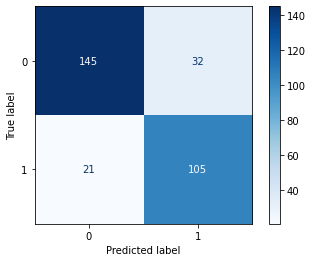

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
labels = [0,1]
cm = metrics.confusion_matrix(output,df["y_real"])
metrics.ConfusionMatrixDisplay.from_predictions(binary_results["y_real"],binary_results["y_pred"], cmap='Blues')

filepath = '/home/rajeckidoyle/Documents/Classification/BACE_Classification/model_benchmarks/results/'
plt.savefig(filepath + best_config.GLOBALPARAMETERS['model_this_run'] + 'confusion_matrix.jpeg', bbox_inches='tight',dpi=100)

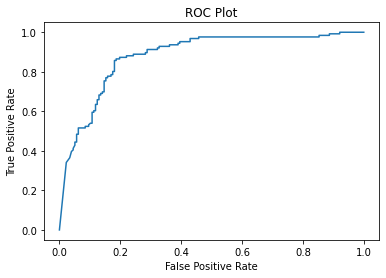

In [ ]:
r_fpr, r_tpr, thresholds = metrics.roc_curve(df["y_real"].to_list(),df["y_pred"].to_list())

roc_curve_data = pd.DataFrame({'r_fpr': r_fpr, 'r_tpr': r_tpr, 'thresholds': thresholds})

filepath = '/home/rajeckidoyle/Documents/Classification/BACE_Classification/model_benchmarks/results/'
roc_curve_data.to_csv(filepath + best_config.GLOBALPARAMETERS['model_this_run']+'rocdata.csv')

import matplotlib.pyplot as plt

plt.plot(r_fpr, r_tpr)
# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

filepath = '/home/rajeckidoyle/Documents/Classification/BACE_Classification/model_benchmarks/results/'
plt.savefig(filepath + best_config.GLOBALPARAMETERS['model_this_run'] + 'roc_curve.jpeg', bbox_inches='tight', dpi=100)

Which metrics should you focus on?

- Choice of metric depends on your business objective
Spam filter (positive class is "spam"): Optimize for precision or specificity because false negatives (spam goes to the inbox) are more acceptable than false positives (non-spam is caught by the spam filter)
- Fraudulent transaction detector (positive class is "fraud"): Optimize for sensitivity because false positives (normal transactions that are flagged as possible fraud) are more acceptable than false negatives (fraudulent transactions that are not detected)

We can change the threshold for predicting a positive/negative class, which will changes the sensitivity and specificity of our model. How we should change this is informed by the ROC curve

### ROC Curve

Plotting the curve

In [ ]:

r_fpr, r_tpr, thresholds = metrics.roc_curve(df["y_real"].to_list(),df["y_pred"].to_list())

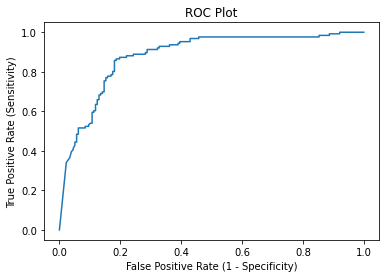

In [ ]:
import matplotlib.pyplot as plt

plt.plot(r_fpr, r_tpr)

# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
# Show plot
plt.show()

You can't directly see the threshold you want from the ROC curve, but you can evaluate the sensitivity and specificity as some specific threshold

In [ ]:
def evaluate_threshold(threshold):
    print('Sensitivity:', r_tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - r_fpr[thresholds > threshold][-1])

evaluate_threshold(0.3)

Sensitivity: 0.8650793650793651
Specificity: 0.8135593220338984


In [ ]:
from sklearn.metrics import average_precision_score
average_precision_score(df["y_real"].to_list(),df["y_pred"].to_list())

0.8212575929742328

In [ ]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(df["y_real"].to_list(),df["y_pred"].to_list())

In [ ]:
from sklearn.preprocessing import binarize
threshold = 0.3
predictions_with_new_threshold = binarize(df["y_pred"].to_numpy().reshape(-1,1), threshold = threshold)
predictions_with_new_threshold

array([[0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],